# Feature-Selection

feature engineering은 모델의 성능을 향상시키는 매우 중요한 단계입니다. 그러나 feature가 너무 많으면 overfitting의 위험이 있고, 모델이 이상적인 방향으로 학습을 하지 않을 위험이 있습니다. 실제로도 feature가 너무 많은 경우 원래 모델보다 성능이 안좋게 나오는 경우가 많습니다. 따라서 feature selection을 해야 합니다.

이 커널에서는 도움이 될 만한 feature들을 모두 추가해본 뒤, feature selection 테크닉들을 통해 중요한 feature만 뽑아내는 방법을 사용하겠습니다.
<br><br>

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./input/train.csv', )

data = data.drop(['sess_dt', 'clnt_id'], axis=1)
data.head()

,action_type,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,grade,day,weekend,time_ct,de_dt,buy_am,buy_ct,clnt_gender,clnt_age,label
0,1,63.0,3.344589,0,1,1.0,0,0,2,0,3.298853,1,0,2,358
1,1,10.0,2.495544,6,1,6.0,0,0,2,0,4.755112,1,0,3,5
2,1,31.0,2.814248,0,1,3.0,0,0,2,0,3.999131,2,0,4,477
3,1,39.0,3.094122,0,1,1.0,0,0,2,0,3.110590,1,0,3,826
4,1,10.0,2.123852,0,1,2.0,0,0,2,0,3.612784,1,0,3,197


# 도움 함수 정의

In [29]:
def top_5_accuracy(y_true, y_pred):
    score = tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
    return  (sum(score) / len(score)).numpy()

def evaluate(x_data, y_data):
    params = {
            'n_estimators' : 1000,
            'boosting_type': 'goss',
            'objective': 'multiclass',
            'num_class':1058,
            'metric': 'multi_logloss', 
            'learning_rate' : 0.009
            }
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1, shuffle=False)

    predictors = x_train.columns.tolist()
    dtrain = lgb.Dataset(x_train.values, label=y_train, feature_name=predictors)
    dvalid = lgb.Dataset(x_val.values, label=y_val, feature_name=predictors)

    lgb_model = lgb.train(params=params,
                  train_set=dtrain,
                  early_stopping_rounds=10, # typical
                  num_boost_round=1000,
                  valid_sets=[dvalid],
                  verbose_eval=False
                 )
    preds = lgb_model.predict(x_val)
    
    
    label = y_val.copy()
    label = np.eye(1058)[label]
    score = top_5_accuracy(label, preds)
    
    del lgb_model
    return score

In [4]:
feats = [col for col in data.columns if col != 'label']
len(feats)

14

# Baseline

In [19]:
params = {
    'n_estimators' : 1000,
    'boosting_type': 'goss',
    'objective': 'multiclass',
    'num_class':1058,
    'metric': 'multi_logloss', 
    'learning_rate' : 0.009
    }
x_data = data.drop(['label'], axis=1)
y_data = data['label']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1, shuffle=False)

predictors = x_train.columns.tolist()
dtrain = lgb.Dataset(x_train.values, label=y_train, feature_name=predictors)
dvalid = lgb.Dataset(x_val.values, label=y_val, feature_name=predictors)

In [20]:
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      early_stopping_rounds=10, # typical
                      num_boost_round=1000,
                      valid_sets=[dvalid],
                      verbose_eval=1
                     )

[1]	valid_0's multi_logloss: 5.99148
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 6.33147
[3]	valid_0's multi_logloss: 6.30013
[4]	valid_0's multi_logloss: 6.43594
[5]	valid_0's multi_logloss: 6.00898
[6]	valid_0's multi_logloss: 6.03029
[7]	valid_0's multi_logloss: 5.99027
[8]	valid_0's multi_logloss: 6.03773
[9]	valid_0's multi_logloss: 5.95919
[10]	valid_0's multi_logloss: 5.94906
[11]	valid_0's multi_logloss: 5.93235
[12]	valid_0's multi_logloss: 5.9256
[13]	valid_0's multi_logloss: 5.90378
[14]	valid_0's multi_logloss: 5.89787
[15]	valid_0's multi_logloss: 5.89318
[16]	valid_0's multi_logloss: 5.85331
[17]	valid_0's multi_logloss: 5.83804
[18]	valid_0's multi_logloss: 5.83508
[19]	valid_0's multi_logloss: 5.82085
[20]	valid_0's multi_logloss: 5.77364
[21]	valid_0's multi_logloss: 5.75548
[22]	valid_0's multi_logloss: 5.74954
[23]	valid_0's multi_logloss: 5.73683
[24]	valid_0's multi_logloss: 5.75594
[25]	valid_0's multi_logloss: 5.72935

In [21]:
preds = lgb_model.predict(x_val)
label = y_val.copy()
label = np.eye(1058)[label]

top_5_accuracy(label, preds)

0.35364202

# Basic Feature Importance

In [32]:
data.head()

,action_type,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,grade,day,weekend,time_ct,de_dt,buy_am,buy_ct,clnt_gender,clnt_age,label
0,1,63.0,3.344589,0,1,1.0,0,0,2,0,3.298853,1,0,2,358
1,1,10.0,2.495544,6,1,6.0,0,0,2,0,4.755112,1,0,3,5
2,1,31.0,2.814248,0,1,3.0,0,0,2,0,3.999131,2,0,4,477
3,1,39.0,3.094122,0,1,1.0,0,0,2,0,3.110590,1,0,3,826
4,1,10.0,2.123852,0,1,2.0,0,0,2,0,3.612784,1,0,3,197


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

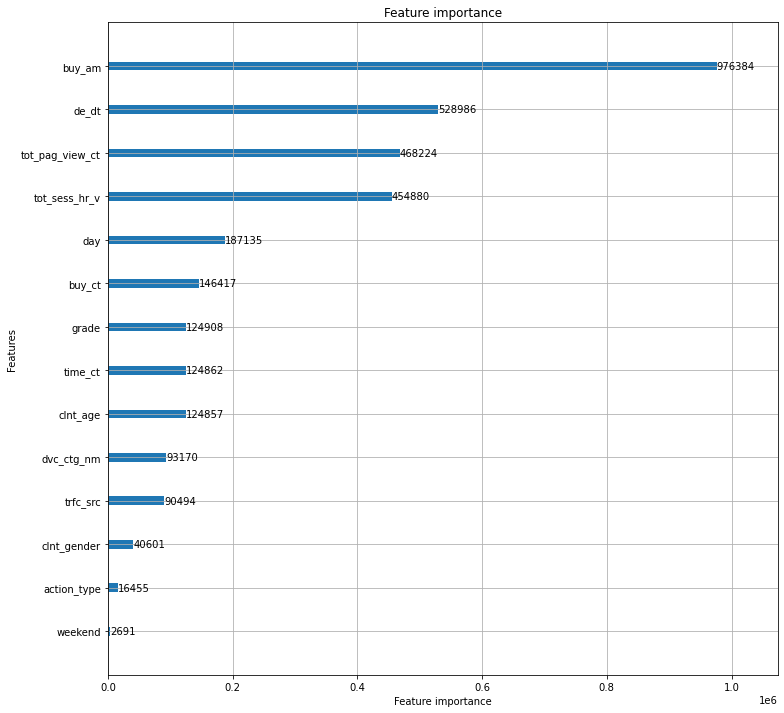

In [31]:
lgb.plot_importance(lgb_model, figsize = (12, 12))

In [12]:
lgb_model.feature_importance()

array([ 257, 8194, 4611,  375,  417,  619, 1090,    1,  576, 4087, 5633,
        621,  156,  627], dtype=int32)

### 2. One-shot

In [30]:
feat_imp = pd.Series(lgb_model.feature_importance(), index=feats).sort_values(ascending=False)
for i in range(7, 14, 1):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['label']))

7 0.12483076
8 0.1870205
9 0.17393267
10 0.1745645
11 0.17483528
12 0.19225562
13 0.35246864
